<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit8/Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

### Task1

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

---

Done 👍

### Task2

What is a decision tree? How do they work?

---

A decision tree is a directed graph used to make predictions. For a given input value, the output is determined by traveling from a non-leaf node to one of its children based on a certain predictive property (typically whether the value is greater of less than some threshold).

### Task3

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

---

The depth of a decision tree is the maximum distance between the root and a leaf node, which can be calculated by looking at the number of levels in the tree. A tree is too deep if the resulting model seems to be overfitting, and it's too shallow if the tree insufficiently predicts patterns in the data.

## Task4

How are BART models similar and different from a decision tree?

---

Bart is an extension of a random forest. The advantages of random forests are that when we have many random trees, and each models something in the data, we can combine them to create a powerful model. In addition to the random forest/ensemble, BART grows trees in a way that allows trees to alter ("boost") each other. Finally, BART actually samples from multiple random forests, which makes it more versatile than a single decision tree or even forest.

### Task5

Why would we use a BART model instead of a decision tree?

---

We would use a BART model when our data is influenced by more than one variable, and especially if there are interactions between variables that a forest might effectively model.

## Bartian Penguins

### Task6

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

---

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import matplotlib.pyplot as plt
import arviz as az

In [2]:
url = "https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"

# Drop the incomplete rows from the data
penguins = pd.read_csv(url).dropna(); penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [3]:
# I combine all my predictor variables into one dataframe
X = penguins[["flipper_length", "bill_depth", "bill_length"]]
Y = penguins["body_mass"].to_numpy()

In [4]:
with pm.Model() as model:
    s = pm.HalfNormal('s', 20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [s]
>PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


### Task7

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

---

In [5]:
pm.sample_posterior_predictive(idata, model, extend_inferencedata=True)

Sampling: [y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

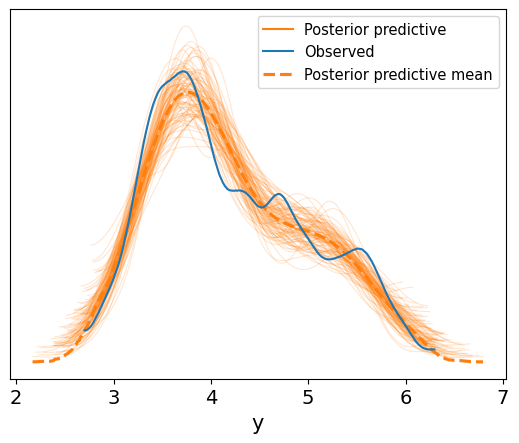

In [6]:
ax = az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

In [9]:
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T

/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


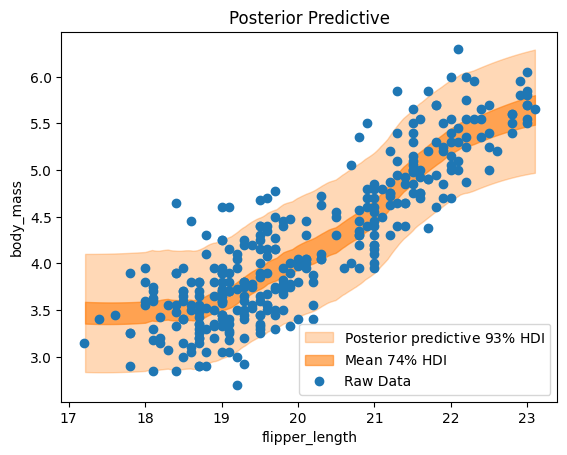

In [19]:
idx = np.argsort(X.to_numpy()[:, 0]) #grab 0th row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab 0th row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab 0th row
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(penguins['flipper_length'], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

### Task8

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

---

I think the plot is very good at capturing the association between flipper length and body mass. I think it captures the true association quite well. The data seems to follow a clear upward sloping trend, with curves accurately reflected in the posterior predictive. Furthermore, the mean is centered, although it seems to be too narrow to capture the uncertainty/variation in the data.

### Task9

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

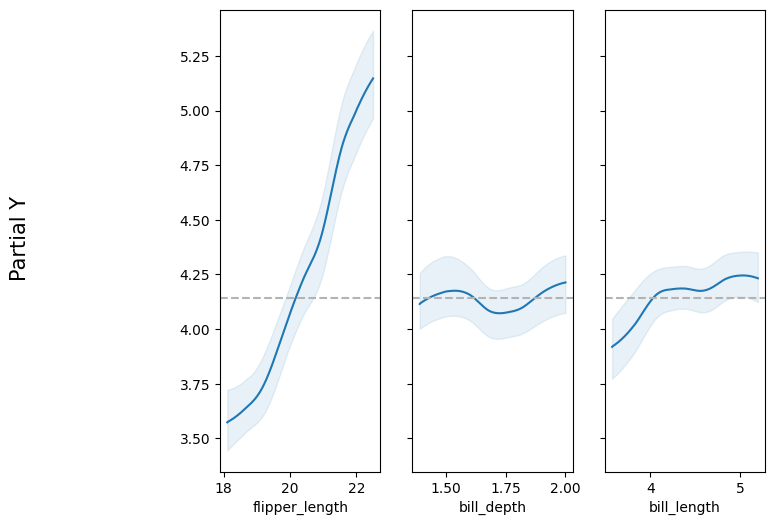

In [20]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

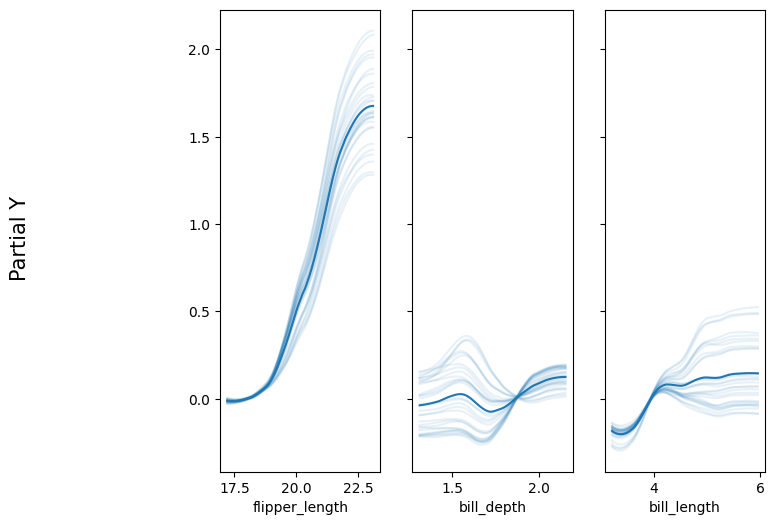

In [21]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In [22]:
vi = pmb.compute_variable_importance(idata, μ_, X)

<Axes: ylabel='R²'>

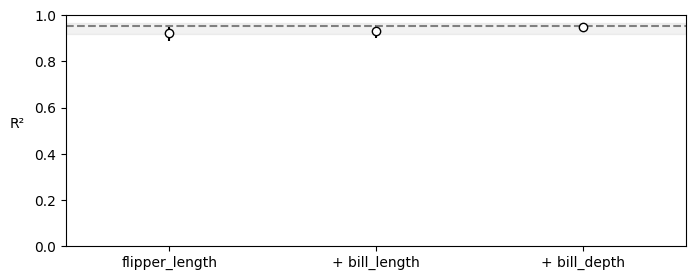

In [24]:
pmb.plot_variable_importance(vi)

## Task10

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

---

The relationship between flipper length and body mass is a positively linear one. The relationship between bill depth and body mass is wavy, but doesn't really diverge from the mean line, indicating that bill depth isn't too useful to get a value for body mass. Bill length is similar, but there is a positive trend for smaller bill length values.

The relationship is complicated by interactions between variables, which I can tell from the ICE plots. Flipper length's lines on the ICE plot are mostly parallel, which shows that there are no interactions that complicate flipper length as a metric. On the other hand, the bill depth graph has a significant variation, indicating an interaction. The same is true for bill length.

The final plot, R^2, shows miniscule jumps between variables and values very close to one. It isn't too helpful to understand what's going on.

From the plots, I found that flipper length is probably good enough to predict body mass, and the other variables don't add much in terms of predictive power. This is because their flat trends on the PDP plot combined with the interactions shown in the ICE plot, but the lack of interactions from the flipper length plot.